In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/research-abstracts/dblp-v10.csv


### Installing Required Libraries

In this notebook, we use `sentence-transformers` for text embedding, which helps convert research paper abstracts into vector representations. These embeddings are essential for topic modeling and classification.

In [77]:
!pip install sentence-transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [78]:
from sentence_transformers import SentenceTransformer


In [79]:
!pip install -U bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Logging into Hugging Face Hub

To access pretrained models and datasets, we log in to the Hugging Face Hub. This provides access to a wide range of NLP resources, including advanced models for embedding generation and topic classification.

The `notebook_login()` function will prompt for credentials to authenticate and enable access to these resources.


In [80]:
from huggingface_hub import notebook_login
notebook_login()

### Setting Up the Model and Device Configuration

We specify the model ID and configure the processing device:

- `model_id` is set to `'meta-llama/Llama-2-7b-chat-hf'`, a powerful language model used for topic classification tasks.
- `device` checks if a GPU (`cuda`) is available for faster processing. If a GPU is available, it sets the device to `cuda`; otherwise, it defaults to the CPU.

This configuration allows efficient model execution, especially beneficial for handling large text data like research abstracts.


In [81]:
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:1


### Configuring Quantization for Efficient Model Loading

To load a large model like `Llama-2-7b-chat-hf` while using less GPU memory, we apply a quantization configuration using the `BitsAndBytesConfig` from the `transformers` library. This step is necessary for memory efficiency, especially when working with high-dimensional data.

- `load_in_4bit=True`: Enables 4-bit quantization to reduce memory usage.
- `bnb_4bit_quant_type='nf4'`: Uses Normalized Float 4 (NF4), a quantization type that provides good accuracy with minimal memory.
- `bnb_4bit_use_double_quant=True`: Applies an additional quantization layer to improve efficiency.
- `bnb_4bit_compute_dtype=bfloat16`: Specifies bfloat16 as the computation data type, balancing memory savings with computation speed.

These configurations help optimize the model's memory footprint on available hardware.


In [82]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

### Loading the Llama 2 Model and Tokenizer

In this section, we initialize the tokenizer and model for `Llama-2-7b-chat-hf`:

- **Tokenizer**: `AutoTokenizer` is loaded using the model ID, enabling text tokenization suitable for input into the Llama 2 model.
- **Model**: `AutoModelForCausalLM` loads the pretrained Llama 2 model with a configuration set for efficient memory usage:
  - `quantization_config=bnb_config` applies the 4-bit quantization settings.
  - `device_map='auto'` automatically assigns the model to available hardware (e.g., GPU if available).

Setting `model.eval()` places the model in evaluation mode, as we are using it for inference rather than training.


In [83]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=

### Setting Up the Text Generation Pipeline

We configure a text generation pipeline using the loaded Llama 2 model and tokenizer. This pipeline will allow us to generate topic predictions and classifications based on research paper abstracts:

- **task='text-generation'**: Specifies the task as text generation, making the model suitable for generating topic labels or summaries.
- **temperature=0.1**: Controls the randomness of predictions; a lower value (like 0.1) makes the output more focused and deterministic.
- **max_new_tokens=500**: Sets the maximum number of new tokens (words or subwords) to generate for each input.
- **repetition_penalty=1.1**: Discourages the model from repeating phrases, leading to more coherent and diverse output.

This pipeline enables efficient and customizable topic extraction from text input.


In [84]:
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

### Defining the System Prompt

We define a system prompt that sets the behavior and role of the assistant (the Llama 2 model) during the text generation process. This prompt:

- Instructs the model to act as a "helpful, respectful, and honest assistant" specifically for labeling topics, ensuring the model generates accurate and contextually relevant outputs for topic classification.
- The prompt format follows a structured instruction set (`<s>[INST]` and `<<SYS>>`), guiding the model on its intended task.

This prompt helps the model understand its role and ensures appropriate responses when processing input data (e.g., research abstracts).


In [85]:
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

In [86]:
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

In [87]:
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

In [88]:
prompt = system_prompt + example_prompt + main_prompt

### Loading the Dataset

The dataset is loaded from the CSV file `dblp-v10.csv` using `pandas`. The `head()` function displays the first few rows to give an overview of the data structure.


In [89]:
import pandas as pd
dataset = pd.read_csv("/kaggle/input/research-abstracts/dblp-v10.csv")
dataset.head()

,abstract,authors,n_citation,references,title,venue,year,id
0,"In this paper, a robust 3D triangular mesh wat...","['S. Ben Jabra', 'Ezzeddine Zagrouba']",50,"['09cb2d7d-47d1-4a85-bfe5-faa8221e644b', '10aa...",A new approach of 3D watermarking based on ima...,international symposium on computers and commu...,2008,4ab3735c-80f1-472d-b953-fa0557fed28b
1,We studied an autoassociative neural network w...,"['Joaquín J. Torres', 'Jesús M. Cortés', 'Joaq...",50,"['4017c9d2-9845-4ad2-ad5b-ba65523727c5', 'b118...",Attractor neural networks with activity-depend...,Neurocomputing,2007,4ab39729-af77-46f7-a662-16984fb9c1db
2,It is well-known that Sturmian sequences are t...,"['Genevi eve Paquin', 'Laurent Vuillon']",50,"['1c655ee2-067d-4bc4-b8cc-bc779e9a7f10', '2e4e...",A characterization of balanced episturmian seq...,Electronic Journal of Combinatorics,2007,4ab3a4cf-1d96-4ce5-ab6f-b3e19fc260de
3,One of the fundamental challenges of recognizi...,"['Yaser Sheikh', 'Mumtaz Sheikh', 'Mubarak Shah']",221,"['056116c1-9e7a-4f9b-a918-44eb199e67d6', '05ac...",Exploring the space of a human action,international conference on computer vision,2005,4ab3a98c-3620-47ec-b578-884ecf4a6206
4,This paper generalizes previous optimal upper ...,"['Efraim Laksman', 'Håkan Lennerstad', 'Magnus...",0,"['01a765b8-0cb3-495c-996f-29c36756b435', '5dbc...",Generalized upper bounds on the minimum distan...,Ima Journal of Mathematical Control and Inform...,2015,4ab3b585-82b4-4207-91dd-b6bce7e27c4e


In [90]:
dataset.shape

(1000000, 8)

In [91]:
dataset.dropna(inplace=True, ignore_index=True)

In [92]:
sampled_df = dataset.sample(n=25000, random_state=1, ignore_index=True)

### Extracting Abstracts

The `abstracts` variable is created by selecting the 'abstract' column from the sampled dataset, which contains the text of the research paper abstracts to be used for topic classification.


In [93]:
abstracts = sampled_df['abstract']

### Extracting Titles

The `titles` variable is created by selecting the 'title' column from the sampled dataset, which contains the titles of the research papers.


In [94]:
titles = sampled_df['title']

In [95]:
abstracts.isna().any()

False

In [96]:
abstracts

0        Spectrum is a limited and precious resource in...
1        The traditional routing protocols for delay to...
2        The non-rigid registration methods, such as co...
3        Desktop grids are platforms for grid computing...
4        Sculptured surface machining (SSM) is an opera...
                               ...                        
24995    This paper presents a robust maximum-likelihoo...
24996    The treatment and processing of Big Data probl...
24997    Demographic attributes play an important role ...
24998    In this research paper, we consider some aspec...
24999    Online social networks such as Facebook, MySpa...
Name: abstract, Length: 25000, dtype: object

### Pre-calculating Embeddings

The `SentenceTransformer` model (`BAAI/bge-small-en`) is used to generate embeddings for the research paper abstracts. These embeddings convert the text into numerical vectors suitable for topic classification. The `encode()` function calculates these embeddings, with progress shown in the console. The `device='cuda'` ensures the calculation uses the GPU for faster processing.


In [97]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True, device='cuda')

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

In [98]:
all_embeddings = np.array(embeddings)
np.save('25k_abstract_embeddings.npy', all_embeddings)

In [99]:
!pip install umap hdbscan BERTopic

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Initializing UMAP and HDBSCAN Models

- **UMAP (Uniform Manifold Approximation and Projection)**: This model is initialized with parameters for dimensionality reduction (`n_neighbors=15`, `n_components=5`, `min_dist=0.0`, and `metric='cosine'`). UMAP reduces the dimensionality of the embeddings to make them more suitable for clustering.
  
- **HDBSCAN (Hierarchical DBSCAN)**: This clustering model is initialized with `min_cluster_size=150` to define the minimum number of samples per cluster. It uses `euclidean` distance for clustering and `eom` (excess of mass) for cluster selection.

These models will be used for reducing the dimensions of the embeddings and clustering them into topics.


In [100]:
from umap import umap_ as UMAP
from hdbscan import HDBSCAN

umap_model = UMAP.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### Reducing Dimensionality with UMAP

UMAP is applied to reduce the dimensionality of the embeddings to 2 components (`n_components=2`). This helps visualize the data in a 2D space. The model uses `n_neighbors=15`, `min_dist=0.0`, and `cosine` distance metric to optimize the reduction process while preserving the structure of the data.


In [101]:
reduced_embeddings = UMAP.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### Initializing Representation Models

Three different representation models are initialized for extracting topics:

- **KeyBERT**: A model inspired by KeyBERT for keyword extraction from text.
- **MMR (Maximal Marginal Relevance)**: A model that balances relevance and diversity in topic extraction with a `diversity` parameter of 0.3.
- **Llama 2 (Text Generation)**: Uses the previously defined `generator` and `prompt` for generating topic-related text through the Llama 2 model.

All these models are stored in a dictionary `representation_model`, making it easy to apply any of them for topic extraction.


In [102]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance()

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

### Training the BERTopic Model

The `BERTopic` model is initialized with several components:

- **Sub-models**:
  - `embedding_model`: The model used for generating embeddings.
  - `umap_model`: UMAP for dimensionality reduction.
  - `hdbscan_model`: HDBSCAN for clustering.
  - `representation_model`: A dictionary of models for topic representation (KeyBERT, MMR, Llama 2).

- **Hyperparameters**:
  - `top_n_words=10`: The number of top words per topic to display.
  - `verbose=True`: Displays progress and information during model training.

The model is then trained using the `fit_transform()` function on the `abstracts` and pre-calculated `embeddings`, returning the identified topics (`topics`) and associated probabilities (`probs`).


In [103]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings)

2024-11-13 14:09:02,864 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-13 14:09:31,424 - BERTopic - Dimensionality - Completed ✓
2024-11-13 14:09:31,426 - BERTopic - Cluster - Start clustering the reduced embeddings
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can

### Retrieving Topic Information

The `get_topic_info()` function is used to retrieve a summary of the topics generated by the `BERTopic` model. This includes information such as the topic IDs, the number of documents associated with each topic, and the most representative words for each topic.


In [104]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,8404,-1_the_of_and_to,"[the, of, and, to, in, is, for, we, that, this]","[algorithms, models, model, networks, algorith...","[Computational Modeling of Complex Systems, , ...","[of, to, for, an, as, data, paper, model, time...",[Agent based computational approach can be fru...
1,0,3109,0_the_of_to_in,"[the, of, to, in, and, is, channel, network, f...","[throughput, networks, network, wireless, rela...","[Wireless Network Performance Optimization, , ...","[channel, network, performance, networks, wire...",[The availability of cost-effective wireless n...
2,1,2182,1_the_image_of_and,"[the, image, of, and, to, is, in, images, we, ...","[segmentation, model, algorithms, algorithm, r...","[Computer Vision and Image Analysis, , , , , ,...","[image, images, method, video, an, from, as, a...",[Similar image/shape retrieval has attractedin...
3,2,1245,2_the_of_speech_and,"[the, of, speech, and, to, in, we, on, for, that]","[language, corpus, learning, model, speech, re...","[Mechanisms of Language Comprehension, , , , ,...","[speech, word, as, web, information, language,...",[Verb omission errors: Evidence of rational pr...
4,3,1088,3_software_and_of_the,"[software, and, of, the, to, in, that, is, thi...","[developers, software, modeling, research, imp...","[Software Development Processes, , , , , , , ,...","[software, process, model, business, developme...","[During the last ten years, a large number of ..."
5,4,907,4_the_of_and_in,"[the, of, and, in, to, brain, is, that, for, w...","[cortical, fmri, cortex, eeg, brain, neural, n...","[Brain Imaging and Analysis, , , , , , , , , ]","[of, brain, for, from, images, using, imaging,...",[The human visual system is capable of recogni...
6,5,822,5_of_protein_the_and,"[of, protein, the, and, gene, to, in, for, dat...","[bioinformatics, microarray, genes, genomic, r...","[Gene Function Prediction and Analysis, , , , ...","[protein, gene, data, genes, from, proteins, s...",[The ability to simultaneously measure mRNA ab...
7,6,784,6_the_test_of_and,"[the, test, of, and, circuit, to, in, is, for,...","[circuits, adc, circuit, cmos, analog, transis...","[Power Efficiency in Digital Circuit Design, ,...","[test, circuit, circuits, fault, cmos, voltage...",[Analog to digital converter (ADC) is the worl...
8,7,713,7_robot_the_of_and,"[robot, the, of, and, to, is, robots, control,...","[robotics, robots, robotic, robot, manipulator...","[Robot Control and Motion Planning, , , , , , ...","[robot, robots, control, an, motion, planning,...",[This paper presents a concept for path planni...
9,8,642,8_the_of_data_learning,"[the, of, data, learning, in, and, to, we, is,...","[regression, classifiers, datasets, clustering...","[Machine Learning for Data Analysis, , , , , ,...","[data, learning, clustering, algorithm, classi...",[This work presents a novel approach to on-lin...


In [105]:
topic_model.get_topic(1, full=True)["KeyBERT"]

[('segmentation', 0.85229975),
 ('model', 0.85014683),
 ('algorithms', 0.8448138),
 ('algorithm', 0.8406571),
 ('recognition', 0.84012467),
 ('representation', 0.83917487),
 ('facial', 0.8385897),
 ('detection', 0.83692324),
 ('classification', 0.8363799),
 ('face', 0.8347727)]

### Assigning Llama 2 Generated Labels to Topics

The Llama 2 model's generated labels are extracted for each topic using a list comprehension. For each topic, the first generated label is retrieved, and the text is processed to get the top label by splitting on newline characters. These labels are then assigned to the topics using the `set_topic_labels()` function, which updates the topic model with the new labels.


In [106]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

### Preparing Data for Visualization and Outlier Removal

1. **Color Mapping**: A color cycle is created using `itertools.cycle` to assign a unique color to each topic. The `color_key` dictionary maps each topic to a color for visualization.
   
2. **Data Preparation**: A DataFrame `df` is created with the following columns:
   - `x` and `y`: The reduced 2D embeddings for visualization.
   - `Topic`: The topic assigned to each document.
   - `Length`: The length of each abstract.

3. **Outlier Removal**:
   - Topics labeled as `-1` (outliers) are removed.
   - The DataFrame is further filtered to keep only points within a defined range on the x and y axes (between -10 and 10).

4. **Centroid Calculation**: The centroids (mean coordinates) of each topic cluster are computed by grouping the data by `Topic` and calculating the mean of the `x` and `y` values for each group.


In [107]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in abstracts]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

In [108]:
!pip install adjustText

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Visualizing Documents with BERTopic

The `visualize_documents()` function is used to generate an interactive visualization of the documents (research paper titles). The 2D embeddings (`reduced_embeddings`) are plotted with the following options:
- `hide_annotations=True`: Hides annotations such as the topic names in the plot.
- `hide_document_hover=False`: Enables hover functionality to display document information when hovering over points in the plot.
- `custom_labels=True`: Uses custom labels (assigned in earlier steps) for the topics in the visualization.


In [109]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

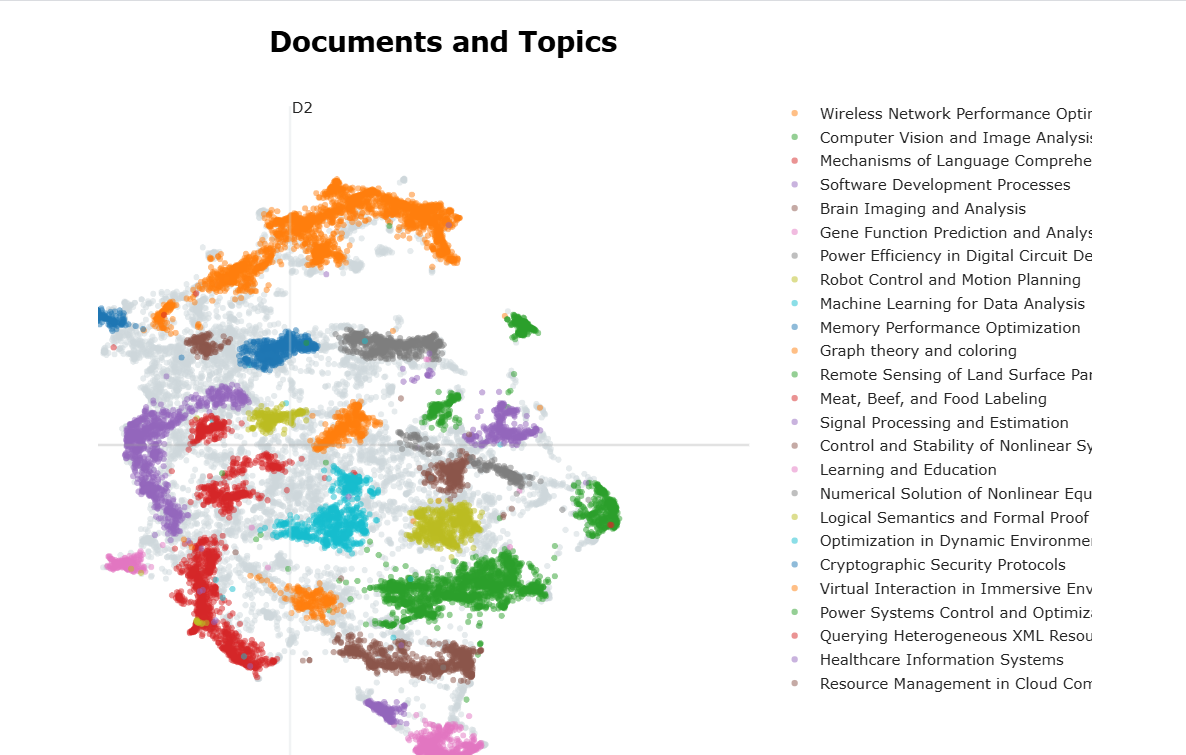

In [110]:
llama2_labels

['Computational Modeling of Complex Systems',
 'Wireless Network Performance Optimization',
 'Computer Vision and Image Analysis',
 'Mechanisms of Language Comprehension',
 'Software Development Processes',
 'Brain Imaging and Analysis',
 'Gene Function Prediction and Analysis',
 'Power Efficiency in Digital Circuit Design',
 'Robot Control and Motion Planning',
 'Machine Learning for Data Analysis',
 'Memory Performance Optimization',
 'Graph theory and coloring',
 'Remote Sensing of Land Surface Parameters',
 'Meat, Beef, and Food Labeling',
 'Signal Processing and Estimation',
 'Control and Stability of Nonlinear Systems',
 'Learning and Education',
 'Numerical Solution of Nonlinear Equations',
 'Logical Semantics and Formal Proof Systems',
 'Optimization in Dynamic Environments',
 'Cryptographic Security Protocols',
 'Virtual Interaction in Immersive Environments',
 'Power Systems Control and Optimization',
 'Querying Heterogeneous XML Resources',
 'Healthcare Information Systems',

This below code extracts representative documents for each topic from the topic model and associates them with corresponding labels. It iterates over the topics, appending each document and its associated topic label into the `abstracts` and `topics` lists, respectively.


In [111]:
abstracts = []
topics = []
for i in range(len(topic_model.get_topic_info()['Representative_Docs'])):
    for abstract in topic_model.get_topic_info()['Representative_Docs'][i]:
               abstracts.append(abstract)
               topics.append(llama2_labels[i])

In [112]:
abstracts_df = pd.DataFrame({'abstract': abstracts, 'topics':topics})
abstracts_df.to_csv("abstracts_topics.csv", index=False)

In [113]:
df_combined = pd.merge(sampled_df, abstracts_df, on='abstract', how='inner')
df_combined

,abstract,authors,n_citation,references,title,venue,year,id,topics
0,"Let k be an odd natural number ź5, and let G b...","['Carsten Thomassen', 'Yezhou Wu', 'Cun-Quan Z...",1,"['0215da4b-ab04-4e98-9c5f-4f63df6b0351', '16cf...","The 3-flow conjecture, factors modulo k, and t...",Journal of Combinatorial Theory,2016,a0e00488-98ea-408e-941f-1ddbe4b5851d,Graph theory and coloring
1,There have been several techniques proposed fo...,"['Ashraf Aboulnaga', 'Jeffrey F. Naughton']",50,"['0bd367f0-7925-406e-afed-9379d85e9eb9', '180c...",Building XML statistics for the hidden web,conference on information and knowledge manage...,2003,71941397-b2c8-45c6-b707-bb2110cf183e,Querying Heterogeneous XML Resources
2,AbstractRecent increased interest in computati...,"['Ibrahim Cetin', 'Christine Andrews-Larson']",0,"['025143ca-b6dc-4fd6-bae7-7340f6f5fac3', '142e...",Learning sorting algorithms through visualizat...,Computer Science Education,2016,5186ecae-bf40-4c3f-86df-7317fcefc1cb,Learning and Education
3,Distributed word representation in a vector sp...,"['Juan Pablo Posadas-Durán', 'Helena Gómez-Ado...",0,"['067b3f03-c2c8-4eaf-b947-8fad5abe7673', '08b9...",Application of the distributed document repres...,soft computing,2017,ba664ac3-2033-4d9a-b963-f8f5a0f48095,Mechanisms of Language Comprehension
4,The distribution of soil moisture is important...,"['Xiaojing Bai', 'Binbin He', 'Xiaowen Li']",2,"['075777a0-0075-4d5b-b19c-060ce68cf828', '0f2a...",Optimum Surface Roughness to Parameterize Adva...,IEEE Transactions on Geoscience and Remote Sen...,2016,bc25ef08-0180-48b2-ba20-8239eaeeb26d,Remote Sensing of Land Surface Parameters
...,...,...,...,...,...,...,...,...,...
73,Minimizing power consumption is one of the mos...,"['Behnam Ghavami', 'Mehrshad Khosraviani', 'Ho...",4,"['281b8776-303b-46e1-b401-1998f69954a2', '2af0...",Power Optimization of Asynchronous Circuits th...,digital systems design,2008,599d2d21-2399-4093-92b1-1b2a2c1f0ebf,Power Efficiency in Digital Circuit Design
74,To provide secure communication for mobile dev...,"['Ai Fen Sui', 'Lucas Chi Kwong Hui', 'Siu-Min...",50,"['1a8b3c2c-f128-46a7-925a-61f30c155bdb', '229b...",An improved authenticated key agreement protoc...,wireless communications and networking conference,2005,d32336ca-1c2b-457d-9b7b-5393d2417394,Cryptographic Security Protocols
75,We propose a new algorithm for the problem of ...,"['Jorge Peña', 'Arlindo L. Oliveira']",74,"['0988f348-d160-4f5a-a547-e0127feaa12d', '099a...",A new algorithm for the reduction of incomplet...,international conference on computer aided design,1998,708e45f9-30e8-4d01-b13d-d03a6771f3c4,Computational Modeling of Complex Systems
76,Cloud computing has attracted much interest re...,"['Guisheng Fan', 'Huiqun Yu', 'Liqiong Chen']",0,"['1ee4b06c-da42-4089-b524-d9d67d69e8e5', '201c...",A Formal Aspect-Oriented Method for Modeling a...,IEEE Transactions on Network and Service Manag...,2016,e6e068db-7d32-445a-a8f7-67094eb5c6a1,Resource Management in Cloud Computing


In [147]:
df_combined['year'].isna().any()

False

### Then we construct a  graph based on the cosine similarity between topic embeddings. It performs the following steps:
1. Loads a pre-trained Sentence-BERT model to generate embeddings for the topics.
2. Computes the cosine similarity between all pairs of topics and stores the results in a similarity matrix.
3. Creates edges between topics with similarity above a specified threshold (0.2).
4. Builds a NetworkX graph, where each topic is a node and edges represent high similarity between topics.
5. Visualizes the graph using Matplotlib, with topics as nodes and edges representing the relationships between them.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

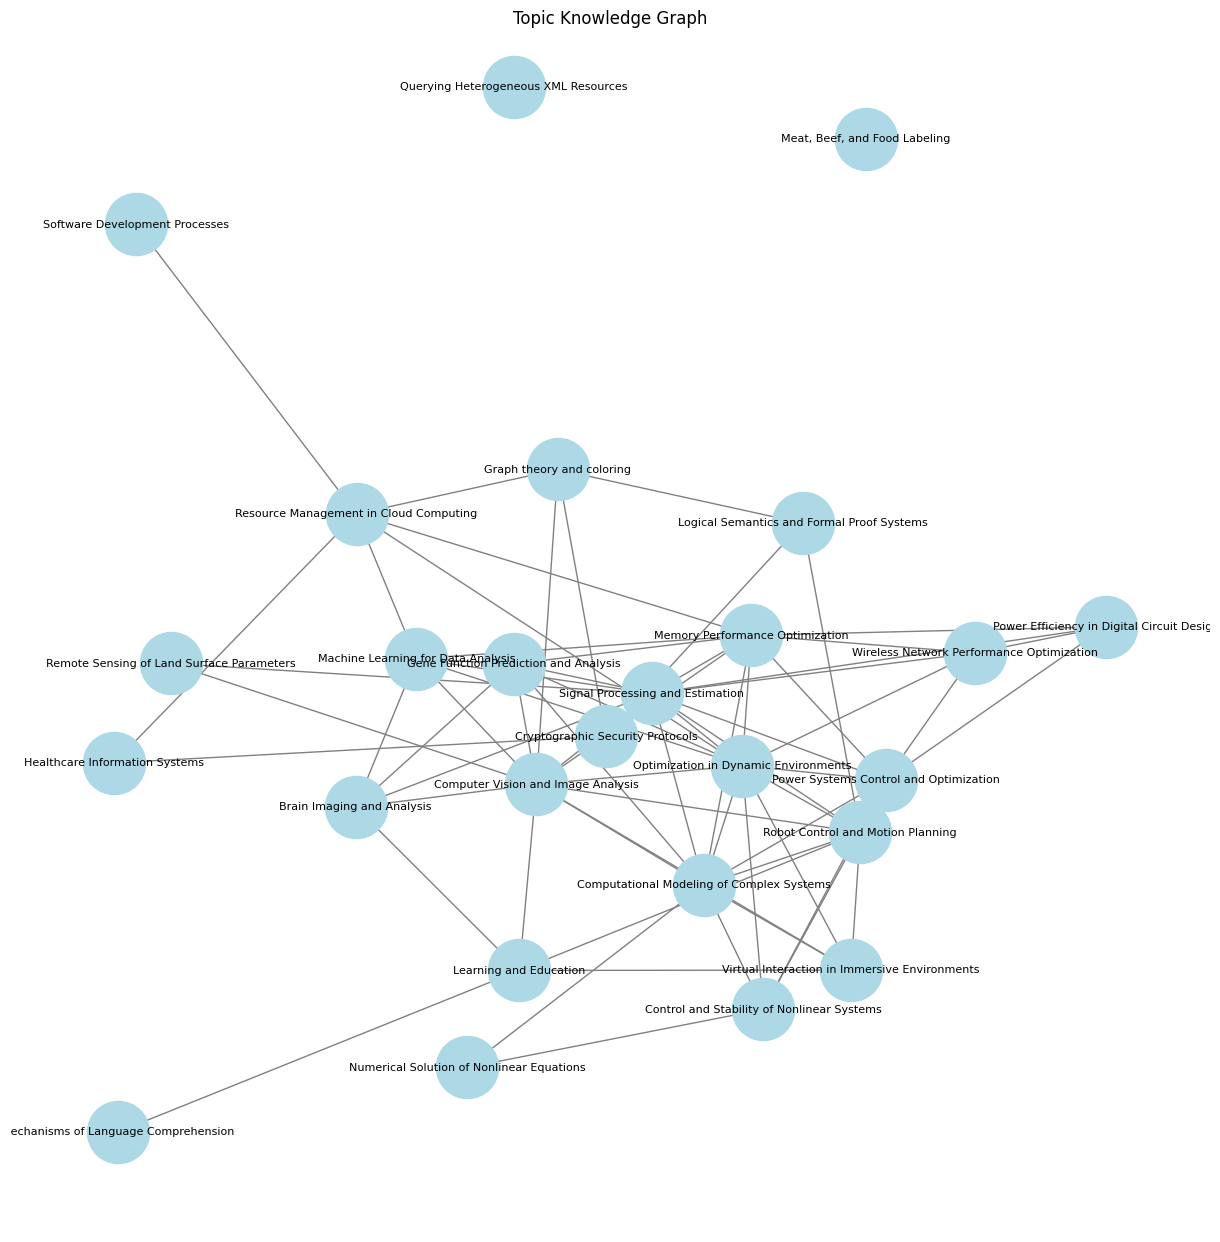

In [166]:
import networkx as nx
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import numpy as np

# List of topics
topics = llama2_labels

# Step 1: Load the pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 2: Generate embeddings for each topic
embeddings = model.encode(topics)

# Step 3: Calculate cosine similarity between all pairs of topics
similarity_threshold = 0.2  # Define threshold for connecting topics
similarity_matrix = np.zeros((len(topics), len(topics)))
edges = []  # To store edges for the graph

for i in range(len(topics)):
    for j in range(i + 1, len(topics)):
        similarity = util.cos_sim(embeddings[i], embeddings[j])
        similarity_matrix[i][j] = similarity
        if similarity > similarity_threshold:
            edges.append((topics[i], topics[j], similarity.item()))

# Step 4: Create a NetworkX graph
G = nx.Graph()

# Add topics as nodes
for topic in topics:
    G.add_node(topic)

# Add edges based on similarity
for topic1, topic2, similarity in edges:
    G.add_edge(topic1, topic2, weight=similarity)

# Step 5: Visualize the knowledge graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # layout for better visualization
nx.draw(G, pos, with_labels=True, font_size=8, node_size=2000, node_color="lightblue", edge_color="gray")

# Display the graph
plt.title("Topic Knowledge Graph")
plt.show()


### This part calculates the **degree centrality** of topics in the graph, which measures the importance of each topic based on how many direct connections (edges) it has. It then sorts the topics by centrality score in descending order and displays the top 5 most central topics.

### Interpretation:
- The top 3 topics, **Computer Vision and Image Analysis**, **Signal Processing and Estimation**, and **Optimization in Dynamic Environments**, all have the same centrality score of **0.48**, indicating they are equally well-connected in terms of similarity to other topics.
- The next two topics, **Computational Modeling of Complex Systems** and **Memory Performance Optimization**, have a slightly lower centrality score of **0.4**, suggesting they are somewhat less connected but still important in the overall graph.
- The centrality values reflect that these topics are likely core themes with high inter-topic similarity, playing a key role in the structure of the topic network.


In [167]:
centrality = nx.degree_centrality(G)
central_topics = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Display top 5 central topics
print("Top 5 Central Topics:")
for topic, score in central_topics[:5]:
    print(f"{topic}: {score}")

Top 5 Central Topics:
Computer Vision and Image Analysis: 0.48
Signal Processing and Estimation: 0.48
Optimization in Dynamic Environments: 0.48
Computational Modeling of Complex Systems: 0.4
Memory Performance Optimization: 0.4


### This segment detects communities in the topic graph using **modularity maximization** and prints the identified communities. The algorithm groups topics that are more densely connected with each other than with other topics. 

### Identified Communities:
- Community 1 focuses on topics related to **learning, education, and computer vision**.
- Community 2 includes topics on **robot control, optimization, and dynamic environments**.
- Community 3 groups topics around **cryptography, software development, and healthcare**.
- Community 4 is centered on **signal processing, memory optimization, and network performance**.
- Other communities are smaller, with niche topics like **food labeling** and **XML querying**.


In [168]:
from networkx.algorithms.community import greedy_modularity_communities

# Detect communities using modularity maximization
communities = list(greedy_modularity_communities(G))
print("Identified Communities:")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {list(community)}")

Identified Communities:
Community 1: ['Learning and Education', 'Brain Imaging and Analysis', 'Computer Vision and Image Analysis', 'Mechanisms of Language Comprehension', 'Gene Function Prediction and Analysis', 'Remote Sensing of Land Surface Parameters', 'Machine Learning for Data Analysis']
Community 2: ['Virtual Interaction in Immersive Environments', 'Robot Control and Motion Planning', 'Power Systems Control and Optimization', 'Numerical Solution of Nonlinear Equations', 'Optimization in Dynamic Environments', 'Computational Modeling of Complex Systems', 'Control and Stability of Nonlinear Systems']
Community 3: ['Cryptographic Security Protocols', 'Logical Semantics and Formal Proof Systems', 'Graph theory and coloring', 'Healthcare Information Systems', 'Software Development Processes', 'Resource Management in Cloud Computing']
Community 4: ['Memory Performance Optimization', 'Signal Processing and Estimation', 'Wireless Network Performance Optimization', 'Power Efficiency in 

Then we assign colors to each community and visualize the graph, where each community is represented by a unique color. The **community_colors** dictionary maps each topic to its corresponding community, and the graph is drawn with nodes colored based on their community membership.

### Visualization:
- The graph is plotted with different colors for each community, providing a clear visual distinction between groups of topics that are more closely related to each other.
- The **spring layout** helps to position nodes in a way that communities are spatially separated, making the community structure easily identifiable.


/tmp/ipykernel_107/1189879635.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



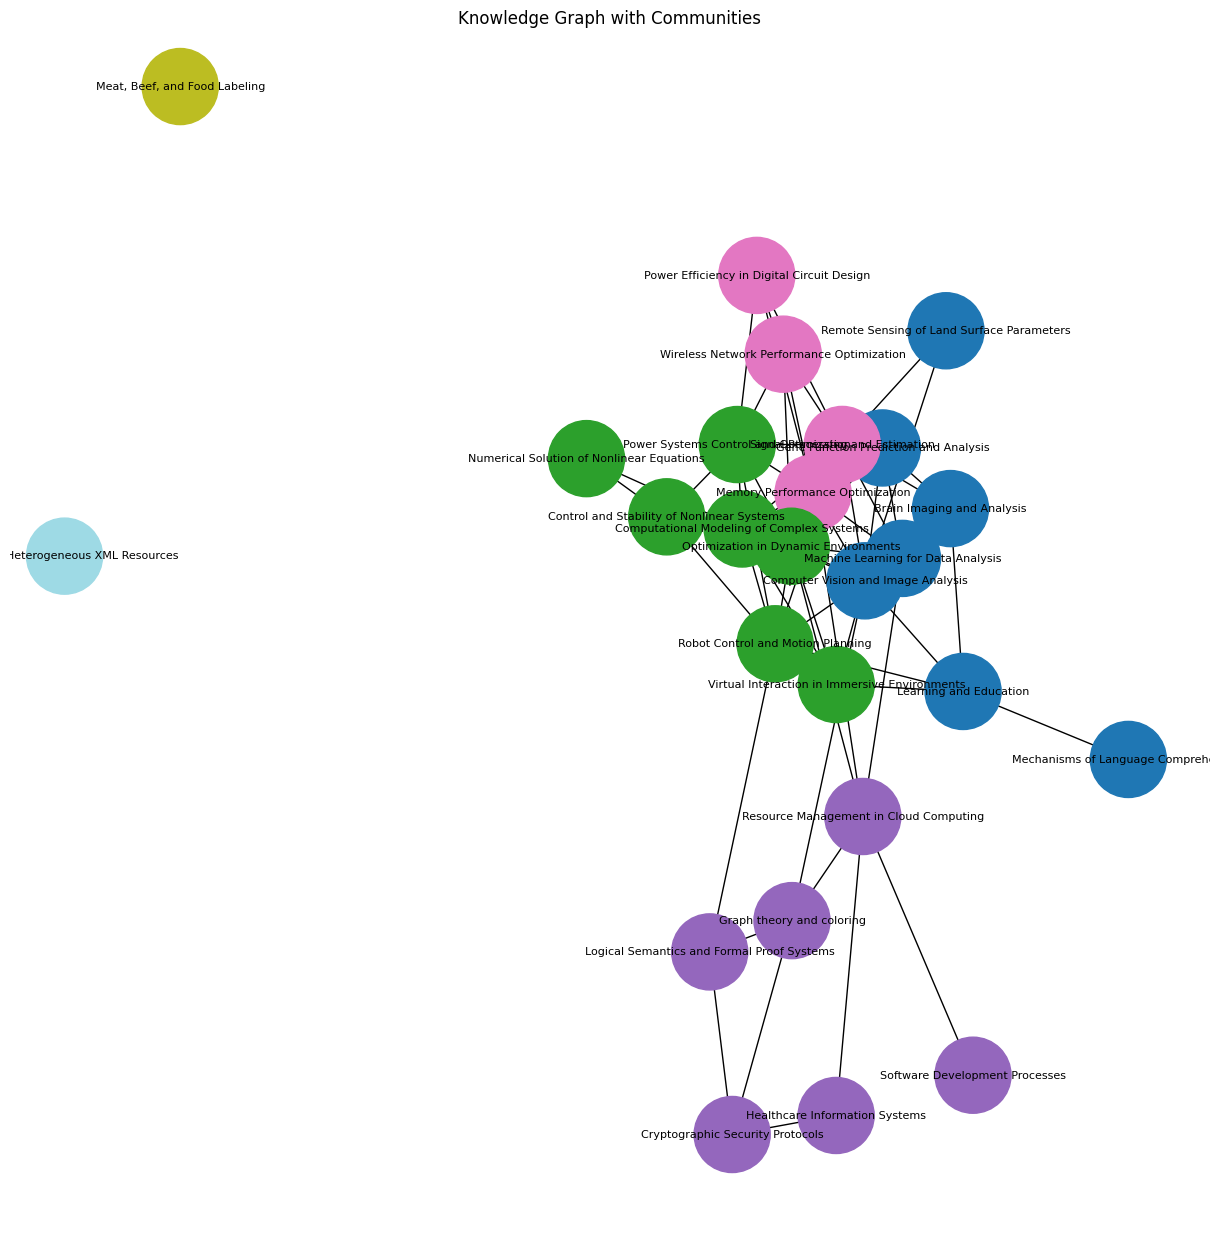

In [169]:
community_colors = {}
for i, community in enumerate(communities):
    for topic in community:
        community_colors[topic] = i

# Plot the graph with communities in different colors
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=3000, node_color=[community_colors.get(node, -1) for node in G.nodes], cmap=plt.cm.get_cmap('tab20'))
plt.title("Knowledge Graph with Communities")
plt.show()

### For further analysis we extract and visualize a **subgraph** centered around a specific topic of interest, **"Machine Learning for Data Analysis"**. It gathers the neighboring nodes (topics) connected to this topic, including the topic itself, and creates a subgraph for these nodes.

### Visualization:
- The subgraph is drawn with nodes representing topics related to **Machine Learning for Data Analysis**, colored in **light blue**.
- The edges indicate the relationships between the topic of interest and its neighbors, allowing for a focused view of how this specific topic connects within the larger topic graph.


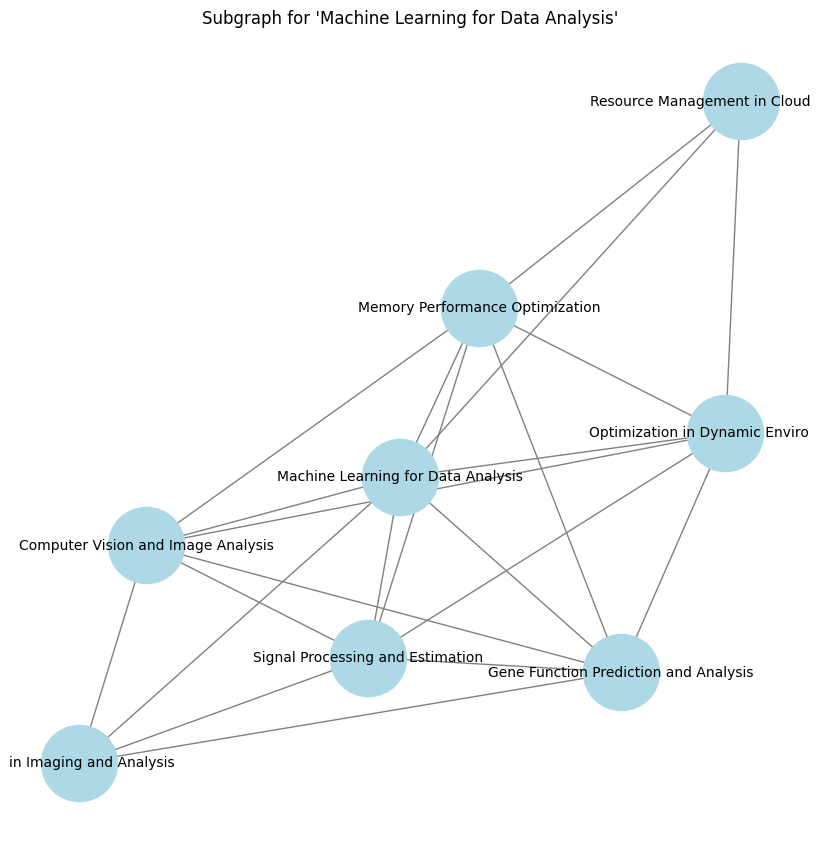

In [170]:
topic_of_interest = "Machine Learning for Data Analysis"
subgraph_nodes = list(G.neighbors(topic_of_interest)) + [topic_of_interest]
subgraph = G.subgraph(subgraph_nodes)

# Visualize the subgraph
plt.figure(figsize=(8, 8))
nx.draw(subgraph, with_labels=True, font_size=10, node_size=3000, node_color="lightblue", edge_color="gray")
plt.title(f"Subgraph for '{topic_of_interest}'")
plt.show()

This part calculates **edge betweenness centrality** for each edge in the graph, which measures the importance of an edge based on how frequently it lies on the shortest paths between other nodes. It then displays the top 5 edges with the highest betweenness centrality.

These edges represent key connections between topics that play significant roles in connecting other parts of the graph. High betweenness centrality suggests these edges serve as bridges between communities or important topic areas.


In [171]:
edge_betweenness = nx.edge_betweenness_centrality(G)

# Display Top 5 Edges by Betweenness Centrality
top_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 Edges by Betweenness Centrality:")
for edge, centrality in top_edges[:5]:
    print(f"{edge}: {centrality:.4f}")


Top 5 Edges by Betweenness Centrality:
('Computer Vision and Image Analysis', 'Graph theory and coloring'): 0.0829
('Optimization in Dynamic Environments', 'Resource Management in Cloud Computing'): 0.0789
('Robot Control and Motion Planning', 'Logical Semantics and Formal Proof Systems'): 0.0758
('Mechanisms of Language Comprehension', 'Learning and Education'): 0.0708
('Software Development Processes', 'Resource Management in Cloud Computing'): 0.0708


### K-Cores
This segment calculates the **core number** for each node in the graph, which measures the highest order of a core in which the node belongs. It identifies the nodes that are part of the **highest core** in the graph.

The nodes with the highest core number are the most well-connected, forming the **core** of the graph. These nodes are typically central to the network and represent the most interconnected topics. The specific topics that belong to the highest core are displayed, showing their key position in the topic network.


In [173]:
k_cores = nx.core_number(G)

# Display nodes with highest core number
max_core = max(k_cores.values())
core_nodes = [node for node, core in k_cores.items() if core == max_core]
print(f"\nNodes in the Highest Core (k={max_core}): {core_nodes}")


Nodes in the Highest Core (k=5): ['Computational Modeling of Complex Systems', 'Computer Vision and Image Analysis', 'Gene Function Prediction and Analysis', 'Robot Control and Motion Planning', 'Machine Learning for Data Analysis', 'Memory Performance Optimization', 'Signal Processing and Estimation', 'Optimization in Dynamic Environments', 'Power Systems Control and Optimization']


## Conclusion

### In conclusion, our work provides an approach to analyzing research literature across critical domains using a combination of advanced techniques. By leveraging LLaMA 2 for generating semantic embeddings, we utilized BERTopic for topic modeling, UMAP for dimensionality reduction, and MMR for topic relevance enhancement. These embeddings were clustered with HDBSCAN to uncover meaningful research themes and subtopics within healthcare, economics, climate change, psychology, and artificial intelligence. The integration of graph analytics, including centrality, community detection, k-core analysis, and subgraph analysis, allowed us to uncover hidden patterns, identify influential paper and key research connections.This comprehensive framework offers deep insights into research landscapes.
